***1. Import Dependencies***

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import numpy as np
import joblib

In [2]:
# Função para adicionar ruído gaussiano (Data Augmentation)
def add_gaussian_noise(data, mean=0, std=0.01):
    noise = np.random.normal(mean, std, data.shape)  # Gerar ruído gaussiano
    return data + noise  # Adicionar ruído aos dados originais


***2. Load the dataset***

In [3]:
# loading the dataset to a pandas dataframe
diabetes_dataset = pd.read_csv('/content/diabetes.csv')

***3. Inspect the Dataset***

In [4]:
diabetes_dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# Check the number of columns and presence of any missing values
print("Dataset dimensions (rows, columns):", diabetes_dataset.shape)
print("\nMissing values in each column:\n", diabetes_dataset.isnull().sum())

Dataset dimensions (rows, columns): (768, 9)

Missing values in each column:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [6]:
# verificar os tipos de dados e a presença de valores ausentes.
diabetes_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
# Verificar se existem duplicatas
has_duplicates = diabetes_dataset.duplicated().any()
print(f"Existem duplicatas: {has_duplicates}")

Existem duplicatas: False


***4. Statistical Summary of Dataset***

In [8]:
# Check the distribution of labels (last column)
print("Class distribution:\n", diabetes_dataset['Outcome'].value_counts(normalize=True))

print("Class distribution:\n", diabetes_dataset['Outcome'].value_counts())

Class distribution:
 Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64
Class distribution:
 Outcome
0    500
1    268
Name: count, dtype: int64


In [9]:
# Getting the statistical measures of the data
diabetes_dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


***5. Separate Features and Labels (after inspection)***

0 - non-diabetic

1 - diabetic

In [10]:
# separate data and labels
X = diabetes_dataset.drop(columns='Outcome', axis=1)
Y = diabetes_dataset['Outcome']

In [11]:
print(X)
print(Y)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  
0                       0.627   50  
1                       0.351   31  


In [12]:
# Display the features to verify separation
print("Features shape:", X.shape)
print("Labels shape:", Y.shape)

Features shape: (768, 8)
Labels shape: (768,)


***Class Distribution Analysis (mean values grouped by labels)***

In [13]:
diabetes_dataset.groupby('Outcome').mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


***8. Exploratory Data Analysis (EDA)***

***8.1 Data Distribution (Histograms)***

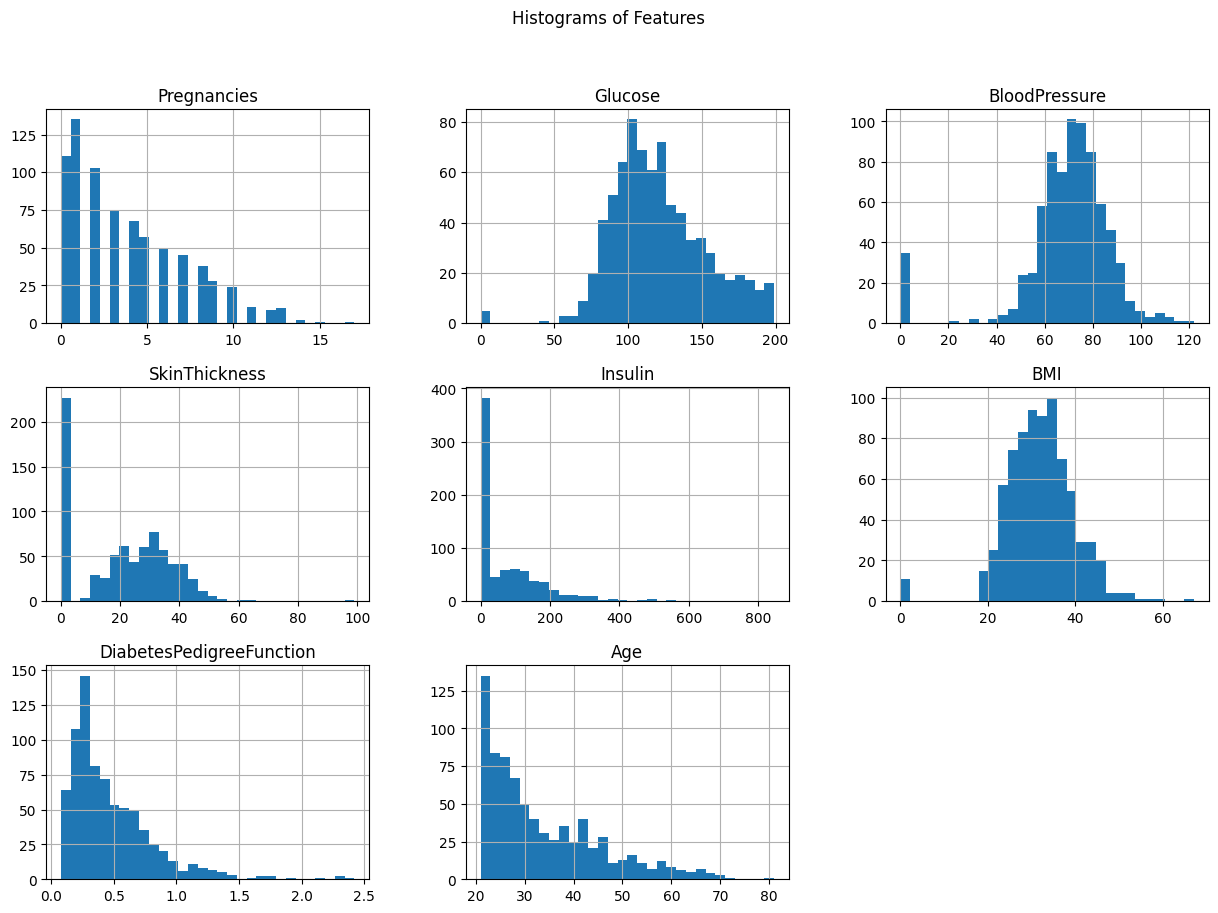

In [14]:
# Histogram for each feature - Histograms show the distribution of each feature and help identify patterns or anomalies.
X.hist(bins=30, figsize=(15, 10))
plt.suptitle('Histograms of Features')
plt.show()

***8.2 Boxplot for Outliers***

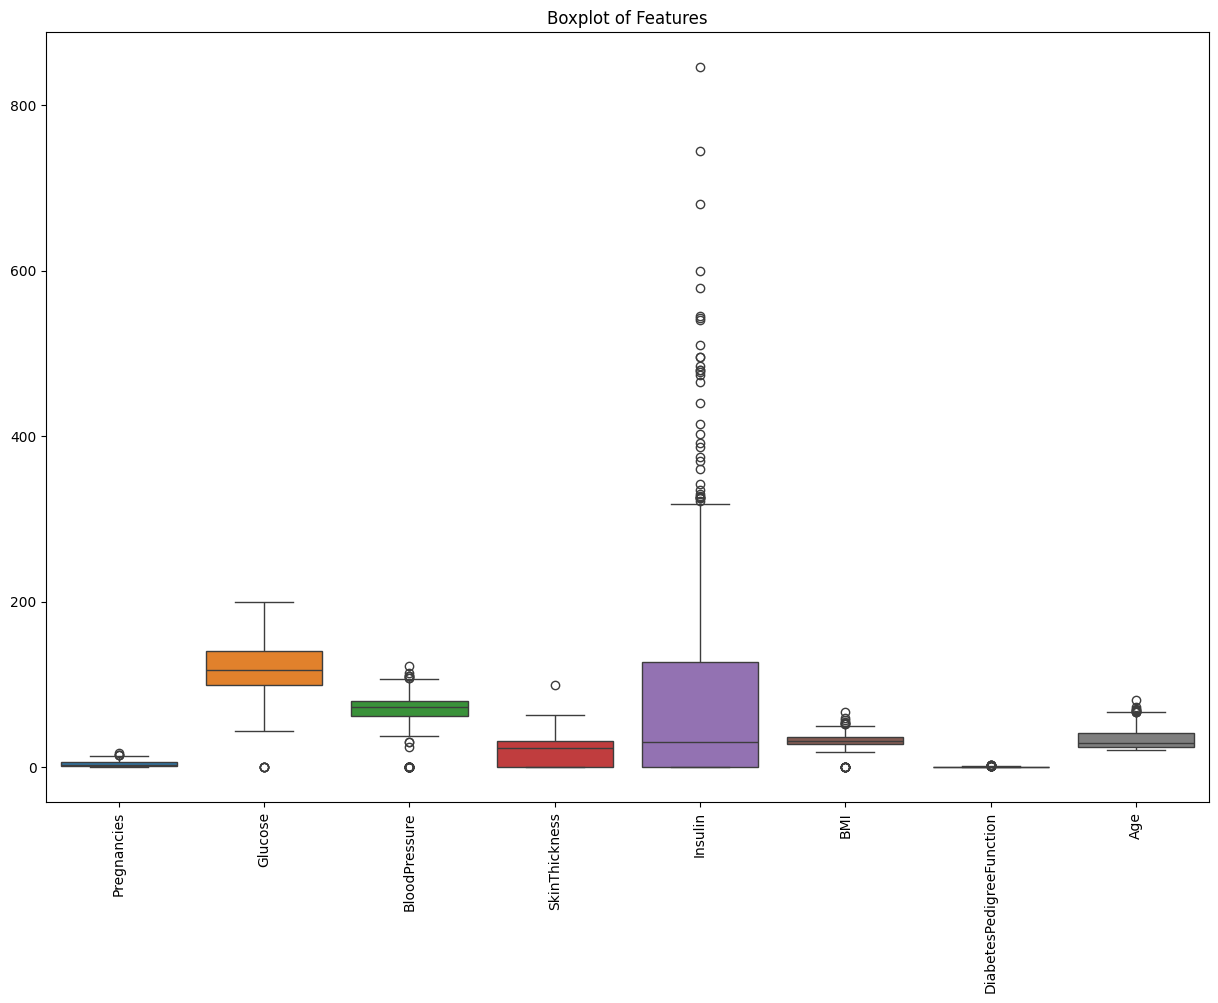

In [15]:
# Boxplot to check for outliers - Boxplots help identify outliers in features, which can be important for model accuracy.
plt.figure(figsize=(15, 10))
sns.boxplot(data=X)
plt.title('Boxplot of Features')
plt.xticks(rotation=90)
plt.show()

***8.3 Correlation Matrix***

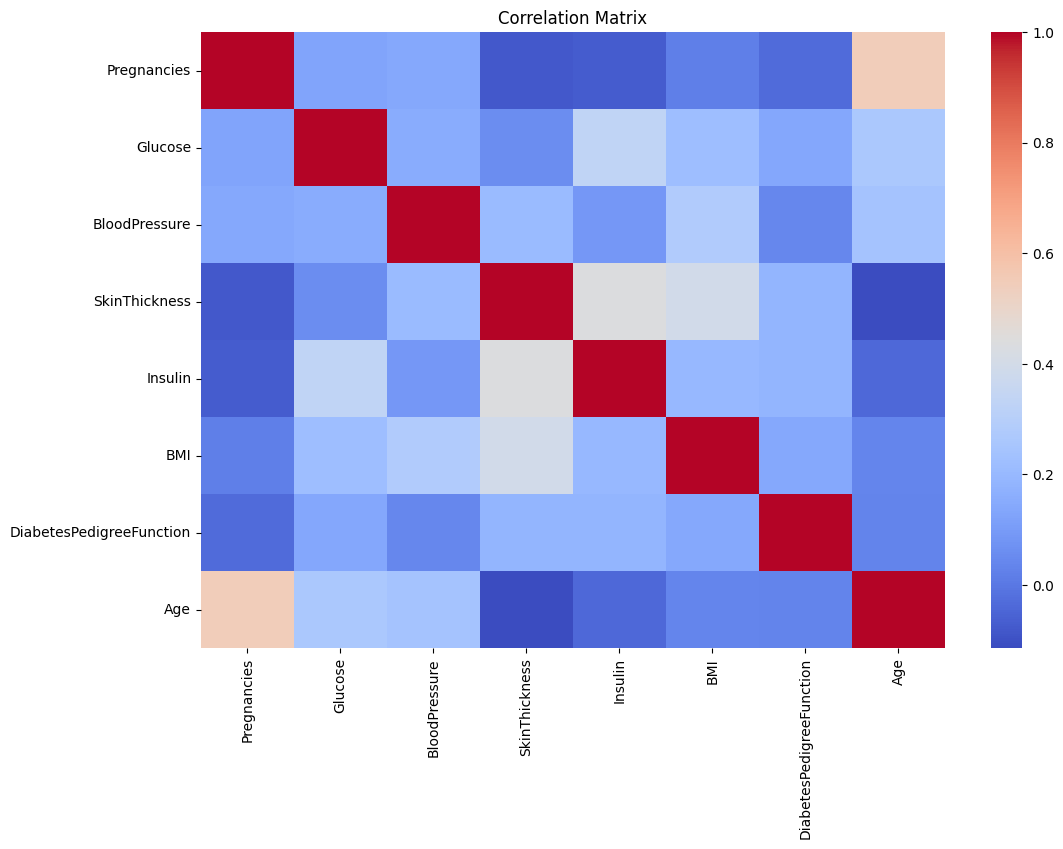

In [16]:
# Calculate correlation only on numeric features
correlation_matrix = X.corr()
# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

***8.4 Outlier Detection (Z-score)***

In [17]:
from scipy import stats

# Outlier detection and treatment (using Z-score)
z_scores = np.abs(stats.zscore(X))  # Calculate the Z-scores
outliers = np.where(z_scores > 3)  # Identify the outliers
print("Number of outliers found:", len(outliers[0]))  # Print the number of outliers

Number of outliers found: 93


In [18]:
# Outlier detection and treatment (using Z-score)
z_scores = np.abs(stats.zscore(X))
outliers = (z_scores > 3).sum(axis=0)
print("Number of outliers per feature:\n", outliers)

Number of outliers per feature:
 Pregnancies                  4
Glucose                      5
BloodPressure               35
SkinThickness                1
Insulin                     18
BMI                         14
DiabetesPedigreeFunction    11
Age                          5
dtype: int64


In [19]:
# Remove Outliers
X_cleaned = X[(z_scores < 3).all(axis=1)]  # Remove rows with outliers
Y_cleaned = Y[(z_scores < 3).all(axis=1)]  # Maintain consistency with the labels

In [20]:
# *** Adding Gaussian noise to the data for augmentation ***
X_noisy = add_gaussian_noise(X_cleaned)  # Add Gaussian noise to the cleaned data

In [21]:
# *** Combine original and noisy data ***
X_augmented = pd.concat([pd.DataFrame(X_cleaned), pd.DataFrame(X_noisy)], axis=0)  # Combine cleaned data with noisy data
Y_augmented = pd.concat([Y_cleaned, Y_cleaned], axis=0)  # Duplicate labels to match the augmented data

print("Size of the original and augmented datasets:")
print("X_augmented shape:", X_augmented.shape)  # Print the shape of the augmented feature set
print("Y_augmented shape:", Y_augmented.shape)  # Print the shape of the augmented label set

Size of the original and augmented datasets:
X_augmented shape: (1376, 8)
Y_augmented shape: (1376,)


In [22]:
# Split the dataset into training and test sets (Original)
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

# *** Split the dataset into training and testing sets with noise and augmentation (Augmented Data) ***
X_train, X_test, Y_train, Y_test = train_test_split(
    X_augmented,  # Augmented feature set
    Y_augmented,  # Augmented labels
    test_size=0.2,  # 20% of the data will be used for testing
    stratify=Y_augmented,  # Ensure that the class distribution is preserved in both train and test sets
    random_state=2  # Set a seed for reproducibility
)


# Display the shapes of the resulting sets
print("Training set shape:", X_train.shape, Y_train.shape)
print("Test set shape:", X_test.shape, Y_test.shape)

Training set shape: (1100, 8) (1100,)
Test set shape: (276, 8) (276,)


Normalização e Padronização

In [23]:
# *** Normalize the data ***
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform the training data
X_test_scaled = scaler.transform(X_test)  # Transform the test data using the same metrics as the training data

# Save the scaler for future use
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [24]:
# After standardization
print("Statistics after standardization:")
print("Mean:", X_train_scaled.mean(axis=0))  # Mean of each feature after scaling
print("Standard deviation:", X_train_scaled.std(axis=0))  # Standard deviation of each feature after scaling

Statistics after standardization:
Mean: [-3.87568765e-17 -2.77757615e-16  9.46313734e-16 -1.29997023e-16
 -5.89427497e-17  2.93906313e-16 -1.13040890e-17 -4.47318950e-16]
Standard deviation: [1. 1. 1. 1. 1. 1. 1. 1.]


In [25]:
# Handle class imbalance only in the training set - SMOTE (Synthetic Minority Over-sampling Technique)
# smote = SMOTE(random_state=2)
# X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_scaled, Y_train)

# Training without SMOTE (using the original scaled data)
X_train_resampled, Y_train_resampled = X_train_scaled, Y_train  # Use the original data

# Display the shapes of the resampled sets
print("Resampled training set shape:", X_train_resampled.shape, Y_train_resampled.shape)

Resampled training set shape: (1100, 8) (1100,)


In [26]:
# Models and their hyperparameters
models = {
    'LogisticRegression': (LogisticRegression(), {'C': [0.1, 1, 10]}),
    'SVC': (SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
    'KNeighborsClassifier': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}),
    'RandomForestClassifier': (RandomForestClassifier(), {'n_estimators': [50, 100], 'max_depth': [None, 10, 20]}),
    'GaussianNB': (GaussianNB(), {}),
    'BernoulliNB': (BernoulliNB(), {}),
    'DecisionTreeClassifier': (DecisionTreeClassifier(), {'max_depth': [None, 10, 20]}),
    'GradientBoostingClassifier': (GradientBoostingClassifier(), {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}),
    'AdaBoostClassifier': (AdaBoostClassifier(), {'n_estimators': [50, 100]}),
    'ExtraTreesClassifier': (ExtraTreesClassifier(), {'n_estimators': [50, 100], 'max_depth': [None, 10, 20]})
}

In [30]:
# Define the best model and best accuracy
best_model = None
best_accuracy_test = 0
best_model_name = ""

# Function to compare models
def compare_models():
    global best_model, best_accuracy_test, best_model_name

    # Use StratifiedKFold to ensure stratification in the folds
    stratified_kfold = StratifiedKFold(n_splits=5)

    for model_name, (model, params) in models.items():
        print(f"Evaluating {model_name}...")

        # GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(model, params, cv=stratified_kfold, scoring='accuracy')
        grid_search.fit(X_train_resampled, Y_train_resampled)

        # Best parameter combination and best validation score
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        print(f"Best parameters for {model_name}: {best_params}")
        print(f"Best cross-validation accuracy for {model_name}: {best_score}")

        # Train and evaluate the model with the best parameters
        best_model_instance = grid_search.best_estimator_

        # Predictions and accuracy on the training set
        train_data_prediction = best_model_instance.predict(X_train_resampled)
        accuracy_train = accuracy_score(Y_train_resampled, train_data_prediction)

        # Predictions and accuracy on the test set
        test_data_prediction = best_model_instance.predict(X_test_scaled)
        accuracy_test = accuracy_score(Y_test, test_data_prediction)

        # Calculate Precision, Recall, and F1-Score on the test set
        precision = precision_score(Y_test, test_data_prediction)
        recall = recall_score(Y_test, test_data_prediction)
        f1 = f1_score(Y_test, test_data_prediction)

        # Update the best model based on test accuracy
        if accuracy_test > best_accuracy_test:
            best_accuracy_test = accuracy_test
            best_model = best_model_instance
            best_model_name = model_name
        '''
        # Mostrar a matriz de confusão
        cm = confusion_matrix(Y_test, test_data_prediction)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f"Confusion Matrix for {model_name}")
        plt.show()'''

        # Show both training and test accuracies
        print(f'Accuracy score for {model_name}: \nTraining: {accuracy_train} \nTest: {accuracy_test}\n')
        print(f'Precision: {precision}, Recall: {recall}, F1-Score: {f1}\n')

    # Display the best model and its accuracy
    print(f"\nThe best model is: {best_model_name} with a test accuracy of {best_accuracy_test}")

# Call the function to compare the models
compare_models()

Evaluating LogisticRegression...
Best parameters for LogisticRegression: {'C': 0.1}
Best cross-validation accuracy for LogisticRegression: 0.7872727272727273
Accuracy score for LogisticRegression: 
Training: 0.7909090909090909 
Test: 0.7862318840579711

Precision: 0.7162162162162162, Recall: 0.5824175824175825, F1-Score: 0.6424242424242425

Evaluating SVC...
Best parameters for SVC: {'C': 10, 'kernel': 'rbf'}
Best cross-validation accuracy for SVC: 0.82
Accuracy score for SVC: 
Training: 0.9181818181818182 
Test: 0.8333333333333334

Precision: 0.7472527472527473, Recall: 0.7472527472527473, F1-Score: 0.7472527472527473

Evaluating KNeighborsClassifier...
Best parameters for KNeighborsClassifier: {'n_neighbors': 5}
Best cross-validation accuracy for KNeighborsClassifier: 0.7818181818181819
Accuracy score for KNeighborsClassifier: 
Training: 0.8572727272727273 
Test: 0.8115942028985508

Precision: 0.7407407407407407, Recall: 0.6593406593406593, F1-Score: 0.6976744186046511

Evaluating Ra

Making a Predictive System

In [28]:
import joblib

# Load the saved scaler (fitted on the training data)
scaler = joblib.load('scaler.pkl')

# Input data for prediction
input_data = (97, 106, 92, 18, 0, 22.7, 0.235, 48)

# Convert input data to a NumPy array
input_data_as_numpy_array = np.asarray(input_data)

# Reshape the array to the format expected by the model
input_data_reshaped = input_data_as_numpy_array.reshape(1, -1)

# If scaling was applied during training, apply the same scaler
input_data_scaled = scaler.transform(input_data_reshaped)

# Make a prediction with the trained model
if best_model is not None:
    prediction = best_model.predict(input_data_scaled)
    print(f"Prediction made using the best model ({best_model_name})")
    print(prediction)

    # Interpreting the prediction
    if prediction[0] == 0:
        print('The person is not diabetic')
    else:
        print('The person is diabetic')
else:
    print('No model available for prediction.')

Prediction made using the best model (ExtraTreesClassifier)
[0]
The person is not diabetic


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
